Hi there. I've grown up watching and playing hockey and figured this NHL data set would be a nice practice project! In this notebook, I create a model using XGBClassifier to predict whether the visiting hockey team will win their game. Still new to this, and definitely welcome to feedback.

First, data importing, parsing, and filtering.  

In [139]:
import numpy as np
import pandas as pd 
import random as rd
import math as mt
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


df = pd.read_csv("../input/nhl-game-data/game.csv", index_col=0, engine='python')

# used extract useful data from the "outcome" column
def parse(row):
    res = row.outcome
    
    winner = 0
    ot = 0
    
    if(res.split()[0] == 'away'): 
        winner = 1
    if(res.split()[2] == 'OT'): 
        ot = 1 
    
    return winner, ot

# apply the function
temp = df.apply(parse, axis=1)

# load two new columns with the data
df['winner'] = pd.Series(list(map(lambda x: x[0], list(temp))), index=df.index)
df['ot'] = pd.Series(list(map(lambda x: x[1], temp)), index=df.index)

# drop columns that are not of interest
to_drop = ['venue_link', 'outcome', 'home_goals', 'date_time_GMT']
df = df.drop(to_drop, axis=1)

print(df.head())

<bound method NDFrame.head of               season type  away_team_id  home_team_id  away_goals  \
game_id                                                             
2016020045  20162017    R             4            16           4   
2017020812  20172018    R            24             7           4   
2015020314  20152016    R            21            52           4   
2015020849  20152016    R            52            12           1   
2017020586  20172018    R            20            24           1   
...              ...  ...           ...           ...         ...   
2018030415  20182019    P            19             6           2   
2018030416  20182019    P             6            19           5   
2018030416  20182019    P             6            19           5   
2018030417  20182019    P            19             6           4   
2018030417  20182019    P            19             6           4   

           home_rink_side_start              venue   venue_time_zone_id 

Next, I will check the data for duplicated entries (hockey games registered twice in the dataset) and missing values. I will simply remove the rows containing duplicated entries; however, missing values can be handled in multiple ways. For now, I will simply print the counts of missing values found in each column of the data. 

In [140]:
print("Total Number of rows: {}\n".format(df.shape[0]))

# count duplicate entries 
num_dupl = sum(df.index.duplicated())
print("Duplicated entries: {}\n".format(num_dupl))

# remove duplicated entries from the data set 
df = df[~df.index.duplicated()]

# display the number of missing values 
missing_vals = df.isnull().sum()
print(missing_vals)

prop = 1099/df.shape[0]
print("\nPercent Missing: {:.2f}".format(prop*100))

Total Number of rows: 26305

Duplicated entries: 2570

season                       0
type                         0
away_team_id                 0
home_team_id                 0
away_goals                   0
home_rink_side_start      1099
venue                        0
venue_time_zone_id           0
venue_time_zone_offset       0
venue_time_zone_tz           0
winner                       0
ot                           0
dtype: int64

Percent Missing: 4.63


It is very fortunate that none of the columns with the exception of 'home_rink_side_start' contain missing entries. Since there is a relatively manageable number of missing values in this column (~5%), I will opt to drop rows containing these NA values so I can use the data in this column.

I will then split my data set into training and validation sets.

In [141]:
from sklearn.model_selection import train_test_split

# remove the values in the dataset with NA "home_rink_side_start" values
df = df.dropna(axis=0)

y_main = df.winner
X_main = df.drop(['winner','venue'],axis=1)     # also drop venue because it is problematic

# # originally thought to create an additional test set  
# split = mt.ceil(df.shape[0] * 0.80)
# sample = rd.sample(range(0,df.shape[0]),split)

# # split up the X into test and main
# X_test = X.drop(X.index[sample], axis=0)
# X_main = X.iloc[sample,:]

# # split up the y into test and main
# y_test = y.drop(y.index[sample], axis=0)
# y_main = y.iloc[sample]


# split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_main, y_main, train_size=0.8, test_size=0.20, random_state=0)


Next up, I will encode my categorical variables. A quick check revealed that the cardinality of these variables range from 2 (binary) to 33. Since I don't want to add too many columns to the data set, I will encode variables with more than 5 entries using label encoding and those with 5 or less entries using one hot encoding. Here, I labelled these columns 'low_card' and 'high_card' and applied the respective encoding to both sets.


In [142]:
# retrieve all the categorical variables 
categorical = [name for name in X_train.columns if X_train[name].dtype == 'object']

# catch the categorical variables that are encoded numerically
categorical = categorical + ['season' , 'away_team_id','home_team_id', 'venue_time_zone_offset']

# find the cardinality of all categorical variables
nunique = {x: X_train[x].nunique() for x in categorical}
print(nunique)
print('')

# stratify into high and low cardinality 
high_card = [x for x in nunique if nunique[x] > 5]
low_card = [y for y in nunique if y not in high_card]
print(high_card)
print(low_card)


{'type': 2, 'home_rink_side_start': 2, 'venue_time_zone_id': 11, 'venue_time_zone_tz': 8, 'season': 19, 'away_team_id': 33, 'home_team_id': 30, 'venue_time_zone_offset': 5}

['venue_time_zone_id', 'venue_time_zone_tz', 'season', 'away_team_id', 'home_team_id']
['type', 'home_rink_side_start', 'venue_time_zone_offset']


Now I'll apply the appropriate preprocessing to both the high and low cardinality variables.   

In [143]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

new_X_train = X_train.copy()
new_X_valid = X_valid.copy()

# label encoding for high cardinality columns 
myEncoder = LabelEncoder()
for col in high_card:
    new_X_train[col] = myEncoder.fit_transform(X_train[col])
    new_X_valid[col] = myEncoder.transform(X_valid[col])

# one hot encoding for low cardinality columns 
OHEncoder = OneHotEncoder(handle_unknown='error', sparse=False)

new_train_cols = pd.DataFrame(OHEncoder.fit_transform(X_train[low_card] ))
new_valid_cols = pd.DataFrame(OHEncoder.transform(X_valid[low_card]))

new_train_cols.index = X_train.index
new_valid_cols.index = X_valid.index

# remove the original columns 
OH_X_train = new_X_train.drop(low_card, axis=1)
OH_X_valid = new_X_valid.drop(low_card, axis=1)

# concatenate the new columns to form the final data frame
OH_X_train = pd.concat([OH_X_train, new_train_cols], axis=1)
OH_X_valid = pd.concat([OH_X_valid, new_valid_cols], axis=1)

# encode the y values as numeric outputs 
y_train = myEncoder.fit_transform(y_train)
y_valid = myEncoder.transform(y_valid)



I then chose to fit an XGBClassifier model to the data, selecting the `binary:logistic` objective to ensure that it is correctly predicting the 'winner' outcome that assumes values 0 or 1. After fitting the model, I used it to predict the outcome of the validation data set and scored the results using the `accuracy_score` and `roc_auc_score` metrics from sklearn. 

In [144]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# initialize the model
model = xgb.XGBClassifier(n_estimators=300, 
                      random_state=0, 
                      learning_rate=0.05, 
                      n_jobs=4,
                      objective='binary:logistic',
                      max_depth=10
                     )

# fit the model
model.fit(OH_X_train, y_train, 
          eval_set=[(OH_X_valid, y_valid)], 
          early_stopping_rounds=10)

# get predictions
preds = model.predict(OH_X_valid)

auc = roc_auc_score(y_valid, preds)
print("AUC Score: {:.4f}".format(auc))

acc = accuracy_score(y_valid, preds)
print("Accuracy Score: {:.2f}%".format(acc*100))


[0]	validation_0-error:0.22306
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.21798
[2]	validation_0-error:0.21842
[3]	validation_0-error:0.21533
[4]	validation_0-error:0.21511
[5]	validation_0-error:0.21400
[6]	validation_0-error:0.21334
[7]	validation_0-error:0.21422
[8]	validation_0-error:0.21378
[9]	validation_0-error:0.21466
[10]	validation_0-error:0.21356
[11]	validation_0-error:0.21290
[12]	validation_0-error:0.21334
[13]	validation_0-error:0.21356
[14]	validation_0-error:0.21290
[15]	validation_0-error:0.21246
[16]	validation_0-error:0.21201
[17]	validation_0-error:0.21179
[18]	validation_0-error:0.21201
[19]	validation_0-error:0.21224
[20]	validation_0-error:0.21224
[21]	validation_0-error:0.21201
[22]	validation_0-error:0.21179
[23]	validation_0-error:0.21268
[24]	validation_0-error:0.21201
[25]	validation_0-error:0.21312
[26]	validation_0-error:0.21312
[27]	validation_0-error:0.21201
Stopping. Best iteration:
[17]	validation_0-erro

# k-fold Cross-Validation

I still want to practice more, so next I will use k-fold cross-validation to evaluate model performance. 

First, I need to process the original `X_main` and `y_main` datasets using the same steps that I applied to `X_train`, `X_valid`, `y_train`, and `y_valid`. 

In [145]:
new_X_main = X_main.copy()

# label encoding for high cardinality columns 
myEncoder = LabelEncoder()
for col in high_card:
    new_X_main[col] = myEncoder.fit_transform(X_main[col])

# one hot encoding for low cardinality columns 
OHEncoder = OneHotEncoder(handle_unknown='error', sparse=False)
new_main_cols = pd.DataFrame(OHEncoder.fit_transform(X_main[low_card] ))

new_main_cols.index = X_main.index

# remove the original columns 
OH_X_main = new_X_main.drop(low_card, axis=1)

# concatenate the new columns to form the final data frame
OH_X_main = pd.concat([OH_X_main, new_main_cols], axis=1)

y_main = myEncoder.fit_transform(y_main)

Next, I will load my data into a DMatrix used by XGBoost, then build a cross-validation model using the cv() method. 

In [151]:
from xgboost import cv

params = model.get_xgb_params()
#print(params)
            
dmatrix = xgb.DMatrix(data=OH_X_main, label=y_main)
xgb_cv = xgb.cv(dtrain=dmatrix, params=params, nfold=5,
            num_boost_round=500,
            early_stopping_rounds=10,
            metrics="auc", 
            as_pandas=True, 
            seed=0)

xgb_cv.head()


{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 4, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.893809,0.000983,0.863671,0.003181
1,0.896032,0.001274,0.865057,0.002868
2,0.896808,0.001221,0.865293,0.002953
3,0.898316,0.000728,0.865790,0.002946
4,0.899797,0.000953,0.865924,0.002935


In [152]:
# retrieve the last test-auc-mean result
xgb_cv['test-auc-mean'].tail(1)

26    0.867385
Name: test-auc-mean, dtype: float64

This shows that a higher AUC value was reached using a different set of hyperparameters. 

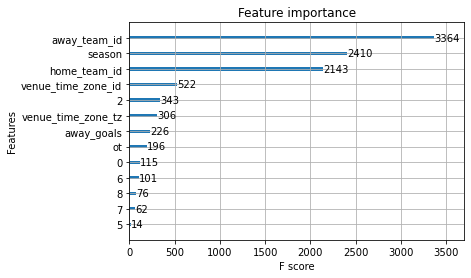

In [147]:
iplot = xgb.plot_importance(model)

Here, we can see the importance scores of the different features. It makes sense that the away and home team IDs are strong predictors of the outcome. However, seeing `season` as a top predictor is odd. I figured I would display the number of away team wins in each season. 

Text(0, 0.5, 'Number of away-wins / Total Games')

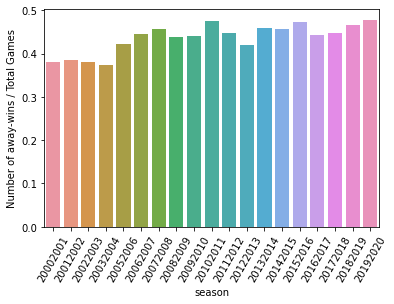

In [149]:
res = df.groupby('season').sum()['winner'] / df.groupby('season').size()

plot = sns.barplot(x=res.index, y=res, data=df)
plot = plot.set_xticklabels(labels=res.index,rotation=60)
plt.ylabel("Number of away-wins / Total Games")

This shows the proportion of visiting team wins relative to the number of recorded games in a given season. It appears like there is a slight upward trend in the proportion of visiting team wins over time, which is fascinating.  

# Conclusions

- In this notebook, I implement XGBoost using Python and Scikit-Learn to predict whether a visiting hockey team will win a game 
- Training an XGBClassifier model with a holdout validation approach yielded an AUC of about 0.77
- It appears that even higher values (0.87) can be reached by fine tuning the hyperparameters
- The `season` variable played a surprising role in predicting whether a visiting team would win
